# Robinson Spectral Model Notes

## Setup

Define some variables

In [16]:
# blah

Importage

In [21]:
import numpy as np
from numpy import pi,abs,exp

## Define functions

Model classes

In [84]:
class Rowe2004Model(object):

    def __init__(self,freqs=None,alpha = 88.,gamma = 71.8, t_0 = 79.2,
                 G_ee = 3.8,G_ei = -8.,G_ese = 10.8, G_esre = -5.7,
                 G_srs = -0.34, p_0 = 2.94,
                 r_e=80.):
        
        # Initialize parameters
        
        """
        self.alpha = alpha
        self.gamma = gamma
        self.t_0 = t_0
        self.G_ee = G_ee
        self.G_ei = G_ei
        #self.G_se = G_se
        self.G_ese = G_es*G_se # G_ese
        self.G_esre = G_es*G_sr*G_re #G_esre
        self.G_srs = G_srs
        self.G_srs = G_srs
        self.c_p_0 = p_0
        
        self.r_e = r_e # what is right value o fthis?
        """;
        
        self.freqs = freqs
        
        # Table 1
        self.sigma_e = 3.3
        self.theta_e = 15.
        self.alpha = 40.
        self.beta_over_alpha = 4.0
        self.beta = self.beta_over_alpha * self.alpha
        
        
        self.r_e = 80.
        self.r_i = self.r_r = self.r_s = None
       
        #self.r_e = 0.08 # from Rowe et al. 2004
        #self.r2 = self.r**2
       
        
        self.va = 8.
        self.t0 = 84.
        self.k0 = 30.
        self.v_ee = self.v_es = self.v_se = 1.2
        self.v_ei = -1.8
        self.v_re = 0.4
        self.v_rs = 0.2
        self.v_sr = -0.8

        self.v_sn_phi_n = 1.0

        self.gamma_e = 130.

        self.gamma_i = self.gamma_r = self.gamma_s = 10E4

        self.Q_a = 250.

        self.G_ee = 6.
        self.G_ei = -7.
        self.G_srs = -0.4
        self.G_esre = -3. 
        self.G_ese = 5.  # G_ese = G_es * G_se

        self.G_es = -0.03 # from Robinson et al. 2001. Can this be calculated from other numbers??
        self.G_se = self.G_ese / self.G_es
        
   
        self.G_rs = 0.1  # from Abeysuria 2015
        self.G_sr = self.G_srs / self.G_rs 

        self.G_re = 0.2  # from Abeysuria 2015
        
        
        self.G_sn = 1. # JG random choice
        self.G_ie = 1. # JG random choice
        
        
        self.lx = 0.5 # from Abeysuria. Unit = m.
        self.ly = 0.5 # from Abeysuria. Unit = m.
        
        
        #self.phi_n = np.random.rand(1,self.freq)  # Rowe et al. 2004 "The driving signalfnis approximated as white noise inspace and time, as in our previous work"
        self.phi_n = np.random.rand(1,self.freqs.shape[0])
        
        
        
        self.freq_min = 5.
        self.freq_max = 100
        
        self.fmax = 50. # near eqn. 14 Rowe
        
        
        
    def compute_L(self,omega):
        # Rowe et al. Eq 
    
        a,b = self.alpha,self.beta
    
        # omega = 2 pi f is angular frequency
        # f is freq in Hz
        L = (1. - 1j*omega / a)**-1 * (1 - 1j*omega / b ) **-1
        return L


    def compute_T(self,omega):
        # Rowe et al. Eq. 9
        
        G_sn,G_sr,G_rs,t0 = self.G_sn,self.G_sr,self.G_rs,self.t0
    
        L = self.compute_L(omega)
    
        T = ( L*G_sn * exp(1j*omega *t0 / 2.)  )  / ( 1 - L*G_sr * L * G_rs)
    
        return T


    def compute_S(self,omega):
        
        G_se,G_sr,G_re,G_rs,t0 = self.G_se,self.G_sr,self.G_re,self.G_rs,self.t0
    
        # Rowe et al. Eq. 10
    
        L = self.compute_L(omega)
    
        S = ( (L * G_se + L * G_sr + L * G_re ) * exp(1j*omega*t0 / 2.) ) / ( 1. - L * G_sr * L * G_rs)
    
        return S


    def compute_q2r2(self,omega):
        
        G_ee,G_es,G_ei,gamma_e = self.G_ee,self.G_es,self.G_ei,self.gamma_e
        
        # Eq 12
        L = self.compute_L(omega)
        S = self.compute_S(omega)
    
        q2r2 = ( 1 - ((1j * omega) / gamma_e))**2    - ( (G_ee * L + G_es * L * S ) / (1 - G_ei * L) )
    
        return q2r2




    def compute_P0(self):
        
        # Eq 13
        
        phi_n,G_es,G_sn,r_e = self.phi_n,self.G_es,self.G_sn,self.r_e
        
        P0 = (( pi * abs(phi_n)**2 ) / r_e**2 ) * G_es * G_sn

        return P0

    def compute_k2r2(self,m,n):
    
        r_e,lx,ly = self.r_e,self.lx,self.ly
    
        term1 = (2. * pi ** m * r_e / lx)**2
        term2 = (2. * pi * n * r_e / ly)**2
    
        return term1 + term2

    
    def compute_P_EEG(self):
    
        G_sn,G_ie,lx,ly,r_e = self.G_sn,self.G_ie,self.lx,self.ly,self.r_e
        k0 = self.k0
        
        P0 = self.compute_P0()
        L = self.compute_L(self.freqs)
        T = self.compute_T(self.freqs)
        q2r2 = self.compute_q2r2(self.freqs)
        
        fmax = self.fmax
        
        
        term1  = P0 * abs(  ((L * T) / G_sn) / ( 1- G_ie * L ) )** 2 * (2 * pi)**2 / (lx*ly)
            
        term2 = 0
        for m in np.arange(-fmax,fmax):
            for n in  np.arange(-fmax,fmax):
                
                k2r2 = self.compute_k2r2(m,n)
                k2 = k2r2/(r_e**2.)
                
                term2+= (exp((-k2**2)/(k0**2)) ) /  abs(k2 * r_e**2. + q2r2) **2                          
                          
                    
        
                    
        return term1 * term2                
        

In [85]:
freqs = np.linspace(0,100)

mod = Rowe2004Model(freqs=freqs)

L = mod.compute_L(freqs)

S = mod.compute_S(freqs)

P0 = mod.compute_P0()#freqs)

EEG = mod.compute_P_EEG()#freqs)



c:\users\john\miniconda2\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: divide by zero encountered in divide
c:\users\john\miniconda2\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: invalid value encountered in divide


In [93]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

df_EEG = pd.DataFrame(np.squeeze(EEG))

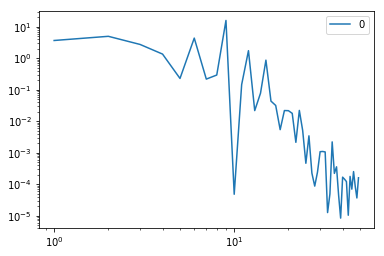

In [99]:
df_EEG.abs().plot(logx=True,logy=True)

In [87]:
plt.plot(EEG)

NameError: name 'plt' is not defined

In [69]:
%debug

> <ipython-input-67-5c34f85fa6a8>(152)compute_P0()
    150         phi_n,G_es,G_sn,r_e = self.phi_n,self.G_es,self.G_sn,self.r_e
    151 
--> 152         P0 = (( pi * abs(phi_n)**2 ) / r_e**2 ) * G_es * G_sn
    153 
    154         return P0

ipdb> r_e
ipdb> l(100,160)
    100         # omega = 2 pi f is angular frequency
    101         # f is freq in Hz
    102         L = (1. - 1j*omega / a)**-1 * (1 - 1j*omega / b ) **-1
    103         return L
    104 
    105 
    106     def compute_T(self,omega):
    107         # Rowe et al. Eq. 9
    108 
    109         G_sn,G_sr,G_rs,t0 = self.G_sn,self.G_sr,self.G_rs,self.t0
    110 
    111         L = self.compute_L(omega)
    112 
    113         T = ( L*G_sn * exp(1j*omega *t0 / 2.)  )  / ( 1 - L*G_sr * L * G_rs)
    114 
    115         return T
    116 
    117 
    118     def compute_S(self,omega):
    119 
    120         G_se,G_sr,G_re,G_rs,t0 = self.G_se,self.G_sr,self.G_re,self.G_rs,self.t0
    121 
    122         # Rowe et 

ipdb> d
> <ipython-input-67-5c34f85fa6a8>(152)compute_P0()
    150         phi_n,G_es,G_sn,r_e = self.phi_n,self.G_es,self.G_sn,self.r_e
    151 
--> 152         P0 = (( pi * abs(phi_n)**2 ) / r_e**2 ) * G_es * G_sn
    153 
    154         return P0

ipdb> r_e
ipdb> c


---

In [51]:
class RobinsonSpectralNFTModel(object):

    def __init__(self,alpha = 88.,gamma = 71.8, t_0 = 79.2,
                 G_ee = 3.8,G_ei = -8.,G_ese = 10.8, G_esre = -5.7,
                 G_srs = -0.34, p_0 = 2.94,
                 r_e=80.):
        
        # Initialize parameters
        
        self.alpha = alpha
        self.gamma = ggamma
        self.t_0 = t_0
        self.G_ee = G_ee
        self.G_ei = G_ei
        self.G_ese = G_es*G_se # G_ese
        self.G_esre = G_es*G_sr*G_re #G_esre
        self.G_srs = G_srs
        self.p_0 = p_0
        
        self.r_e = r_e # what is right value o fthis?
        
    def compute_P_the(self,omega):
        
        p_eeg = self.compute_P_EEG(omega)
        p_emg = self.compute_P_EMG(omega)
        
        return p_eeg + p_emg
    
    
    def compute_P_EEG(self,omega):
        
        G_es,G_sn,r_e,t_0 = self.G_es,self.G_sn,self.r_e,self.t_0
        L,P = self.L,self.P
        
        # Eq. 19
        term1 = ((pi * abs(phi_n)**2) / r_e**2) * G_es**2 * G_sn**2
        term2 = abs(L**2 * exp(i * omega * t0/ 2.))**2 * P
        
        return term1*term2    


    
    def compute_P(self):
        
        r_e,L_x,L_y,ks,k_0 = self.r_e,self.L_x,self.L_y,self.ks,self.K_0
        #r_e,Lx,Ly,ks,k_0,q):
        
        # Eq. 21
        term1 = (4. * pi * r_e**2.)/(L_x*L_y)
    
        term2 = 0
        for m in np.arange(-M,M):
            for n in np.arange(-N,N):
                term2 += exp(L**2,-ks[m,n]**2. / k0**2.) / \
                          abs(ks[m,n]**2,r_e**2 + q**2 * r_e**2)
                      
        return term2 * term2
    
        
    def compute_P_EMG(self,omega):
        
        # Eq. 22
    
        term1 = self.A_EMG
        term2 = (omega/omega_EMG)**2. / (1+ (omega/omega_EMG)**2 )**2
    
        return term1 * term2
    

    
    
                            
        

## Do it

In [24]:
# Table 1
sigma_e = 3.3
theta_e = 15.
alpha = 40.
beta_over_alpha = 4.0
beta = beta_over_alpha * alpha
r_e = 80.
r_i = r_e = r_s = None
va = 8.
t0 = 84.
K0 = 30.
v_ee = v_es = v_se = 1.2
v_ei = -1.8
v_re = 0.4
v_rs = 0.2
v_sr = -0.8

v_sn_phi_n = 1.0

gamma_e = 130.

gamma_i = gamma_r = gamma_s = 10E4

Q_a = 250.

G_ee = 6.
G_ei = -7.
G_srs = -0.4
G_esre = -3. 
G_ese = 5.


#rho_a = 
#G_ee gamma_e    



In [31]:
mod.freqs.max()

100.0

In [54]:
%debug

> <ipython-input-50-5727a3173c47>(155)compute_k2r2()
    153         r_e,lx,ly = self.r_e,self.lx,self.ly
    154 
--> 155         term1 = (2. * pi ** m * r_e / lx)**2
    156         term2 = (2. * pi * n * r_e / ly)**2
    157 

ipdb> r_e
ipdb> lx
0.5
ipdb> pi
3.141592653589793
ipdb> 2.
2.0
ipdb> c


In [43]:
freqs = np.linspace(0,100)

mod = Rowe2004Model(freqs=freqs)

L = mod.compute_L(freqs)

S = mod.compute_S(freqs)

P0 = mod.compute_P0()#freqs)

EEG = mod.compute_P_EEG()#freqs)

c:\users\john\miniconda2\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in divide
c:\users\john\miniconda2\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in divide


TypeError: range() integer end argument expected, got float.

In [1]:
phi_n = np.random.rand(1,100)

NameError: name 'np' is not defined